Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-04-12 22:12:51.074953: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 22:13:02.621560: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<!-- # Project 3 | Word Embeddings and Sentiment Analysis -->
# Project 3 | Word Embeddings

The goal of this project is to gain insight about the representations learned by neural networks — how do they encode the training data internally? We will transition to training neural network on text data — specifically on tens of thousands of real Amazon reviews of fashion products (e.g. clothes, shoes, etc.). 

<!-- Next week, you will train a CNN to predict whether the reviews are positive or negative, a task in the field natural language processing (NLP) called **sentiment analysis**. -->

<!-- #### Week 1: Word Embeddings of Amazon Fashion Reviews -->

This notebook focuses on building the Amazon Fashion Reviews text preprocessing pipeline as well as analyzing and visualizing how a neural network learns to encode words from the reviews. You will train a **Continuous Bag of Words (CBOW)** (word2vec) neural network commonly used in the field of natural language processing (NLP) on text from IMDb user movie reviews. The network attempts to predict a **target word** (a missing word from a passage of text) from the surrounding **context words** (the words surrounding the target word in a sentence). After implementing and training the network, you will extract the weights to obtain $H$ dimensional **word embedding** vectors for English words that appeared in the Amazon reviews to analyze and visualize. 

## Task 1: Preprocessing Amazon Fashion Reviews

### 1a. Download and inspect first several few Amazon reviews

Download the Amazon Fashion dataset (`Amazon_Fashion.jsonl`) from the project website and store it in the `data` subfolder of your working directory. These Amazon reviews were curated by [the McAuley lab in 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023).

In the cell below, use the provided `load_reviews_and_ratings` function in `amazon_reviews.py` to load in the 1st five reviews and ratings. Print these first five reviews and clearly indicate the star rating for each review.

In [8]:
from amazon_reviews import load_reviews_and_ratings

In [3]:
reviews, ratings = load_reviews_and_ratings(N_reviews=5)

for i, (review, rating) in enumerate(zip(reviews, ratings)):
    print(f"Review {i+1}:")
    print(f"Rating: {rating:.1f} stars")
    print(f"Text: {review}\n")

Review 1:
Rating: 5.0 stars
Text: I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I use it when I need to carry medication with me. Closes securely. High quality & very pretty.

Review 2:
Rating: 5.0 stars
Text: Great

Review 3:
Rating: 2.0 stars
Text: One of the stones fell out within the first 2 weeks of wearing it. Stones smaller than expected.

Review 4:
Rating: 1.0 stars
Text: Crappy socks. Money wasted. Bought to wear with my tieks. Don’t stay on feet well.

Review 5:
Rating: 5.0 stars
Text: I LOVE these glasses!  They fit perfectly over my regular, rectangular glasses that I always have to wear in order to see.  I really appreciate having these pretty and stylish and sturdy sunglasses to wear over my glasses.  I'll buy these again and again whenever I need a new pair, which hopefully won't be too soon.



### 1b. Make the corpus

We will use a "flat"/1D list of sentences across the reviews as our **corpus**. That is, we REMOVE information about which review a sentence came from in the corpus. However, we will eventually need this information in order to determine whether a review is positive/negative so we maintain a separate list that indicates to which review a given sentence belongs. For example: Sent 0 belongs to review 0, Sent 1 belongs to review 0, Sent 2 belongs to review 1, etc.

To make sure we have enough context words in sentences, we prune sentences that are too short. We also prune sentences that are too long.

Implement `make_corpus` in `amazon_reviews.py` to create the corpus of sentences and review ID associations.

In [7]:
from amazon_reviews import make_corpus

In [5]:
corpus, sentence_ratings, review_ids = make_corpus(N_reviews=50)
print(f'Number of sentences in the corpus (after pruning short sentences/identifying words): {len(corpus)}.')
print('There should be 185 sentences')
assert len(corpus) == len(sentence_ratings)
assert len(corpus) == len(review_ids)
print(f'The first few sent ratings are: {sentence_ratings[:10]} and should be [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.]')
print(f'The last few sent ratings are: {sentence_ratings[-10:]} and should be [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]')
print(f'The first few review_ids are: {review_ids[:10]} and should be [0 0 0 0 0 2 2 3 3 3]')
print(f'The last few review_ids are: {review_ids[-10:]} and should be [49 49 49 49 49 49 49 49 49 49]')


Number of sentences in the corpus (after pruning short sentences/identifying words): 185.
There should be 185 sentences
The first few sent ratings are: [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.] and should be [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.]
The last few sent ratings are: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.] and should be [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
The first few review_ids are: [0 0 0 0 0 2 2 3 3 3] and should be [0 0 0 0 0 2 2 3 3 3]
The last few review_ids are: [49 49 49 49 49 49 49 49 49 49] and should be [49 49 49 49 49 49 49 49 49 49]


### 1c. Make the vocabulary

We will be training a **word-level model**, so our tokens will be single words. Implement `find_unique_words` to form the **vocabulary**.

In [6]:
from amazon_reviews import find_unique_words

In [7]:
test_text = [['I', 'love', 'CS444'],
             ['I', 'love', 'deep', 'learning'],
             ['I', 'love', 'CS'],
             ['I', 'love', 'Colby']]
unique = find_unique_words(test_text)
print('unique words:\n', unique)
print("unique words should be:\n ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']")

unique_words_corpus = find_unique_words(corpus)
print(f'Number of unique words in the 50 reviews: {len(unique_words_corpus)} and should be 677.')


unique words:
 ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']
unique words should be:
 ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']
Number of unique words in the 50 reviews: 677 and should be 677.


### 1d. Mapping words to indices and back

While our corpus is currently made of word strings we clearly cannot plug these in as inputs to a neural network! We need to convert these word features to numbers first. For the specific CBOW word2vec neural network we are implementing, we *could plug in each word represented as a one-hot vector. To determine the location of the 1 in each vector, we use the word's position in the vocabulary. 

Implement and test `make_word2ind_mapping` to convert a string word to its position index in the vocab and `make_ind2word_mapping` to perform the reverse — looking up a string word based on its int index.

*For efficiency, we won't *actually* plug in one-hot vectors into CBOW. We'll use the int indices instead.

In [5]:
from amazon_reviews import make_word2ind_mapping, make_ind2word_mapping

In [9]:
print(f'For the test text, your word2ind mapping is:\n{make_word2ind_mapping(unique)}')
print('and it should be')
print("{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}")
print()
print(f'The reverse ind2word mapping is:\n{make_ind2word_mapping(unique)}')
print('and it should be')
print("{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}")
print()

For the test text, your word2ind mapping is:
{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}
and it should be
{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}

The reverse ind2word mapping is:
{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}
and it should be
{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}



In [10]:
print(f'For the Amazon text, your word2ind mapping has :\n{len(make_word2ind_mapping(unique_words_corpus))} entries.')
print('and it should have\n677 entries.')
print("{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}")
print()
print(f'For the Amazon text, the reverse ind2word mapping has:\n{len(make_ind2word_mapping(unique_words_corpus))} entries.')
print('and it should have\n677 entries.')

For the Amazon text, your word2ind mapping has :
677 entries.
and it should have
677 entries.
{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}

For the Amazon text, the reverse ind2word mapping has:
677 entries.
and it should have
677 entries.


### 1e. Use the corpus to form context and target word tensors

Together, these make up the data samples and labels on which we will train the CBOW network. To form these tensors, we step through the corpus and identify each word as a target word and surrounding words within the **context window** as context words. To handle the fact that there are an irregular number of context words around each target words, we code samples as individual *pairs* of context and target words and we duplicate target words as needed. For example, for the target word `love` in `I love CS444`, we code add the target word entries of `1, 1` and add context word entries of `0, 2`.

In [11]:
from amazon_reviews import make_target_context_word_lists

Test: context window of 1

In [12]:
test_target_words_int, test_context_words_int = make_target_context_word_lists(test_text,
                                                                               make_word2ind_mapping(unique),
                                                                               context_win_sz=1)
print(f'For the test text, the int-coded target words are:\n{test_target_words_int.numpy()}')
print('and they should be:')
print('[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]')
print(f'For the test text, the int-coded context words are:\n{test_context_words_int.numpy()}')
print('and they should be:')
print('[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]')
# Make sure we have the correct dtype since these will eventually need to serve as indices
assert test_target_words_int.dtype == tf.int32
assert test_context_words_int.dtype == tf.int32

For the test text, the int-coded target words are:
[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]
and they should be:
[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]
For the test text, the int-coded context words are:
[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]
and they should be:
[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]


2025-04-12 20:51:55.889181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20601 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


Test: Default context window of 2

In [13]:
test_target_words_int, test_context_words_int = make_target_context_word_lists(test_text,
                                                                               make_word2ind_mapping(unique))
print(f'For the test text, the int-coded target words are:\n{test_target_words_int.numpy()}')
print('and they should be:')
print('[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]')
print(f'For the test text, the int-coded context words are:\n{test_context_words_int.numpy()}')
print('and they should be:')
print('[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]')

For the test text, the int-coded target words are:
[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]
and they should be:
[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]
For the test text, the int-coded context words are:
[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]
and they should be:
[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]


Test: Amazon reviews

In [14]:
am_target_words_int, am_context_words_int = make_target_context_word_lists(corpus,
                                                                           make_word2ind_mapping(unique_words_corpus))
print(f'For the test text, there are {len(am_target_words_int)} int-coded target words and there should be 6930.')
print(f'For the test text, there are {len(am_context_words_int)} int-coded target words and there should be 6930.')

For the test text, there are 6930 int-coded target words and there should be 6930.
For the test text, there are 6930 int-coded target words and there should be 6930.


### 1f. Function to automate obtaining training samples and labels

Write `get_dataset_word2vec` to to streamline the process of going from the data file to getting the target and context word tensors.

In [4]:
from amazon_reviews import get_dataset_word2vec

In [16]:
targets_int, contexts_int, vocab = get_dataset_word2vec(N_reviews=40000)
print(f'Number of target words in actual Amazon corpus: {len(targets_int)}. There should be 5434338.')
print(f'Number of context words in actual Amazon corpus: {len(contexts_int)}. There should be 5434338.')
print(f'Vocab size in actual Amazon corpus: {len(vocab)}. It should be 21905.')

Number of target words in actual Amazon corpus: 5434338. There should be 5434338.
Number of context words in actual Amazon corpus: 5434338. There should be 5434338.
Vocab size in actual Amazon corpus: 21905. It should be 21905.


## Task 2: Build and train CBOW on Amazon Fashion Reviews

Now that we have the Amazon data in an appropriate format, let's develop the CBOW neural network. It should take far less time to develop this net due to its simplicity.

### 2a. Copy over your deep learning library from Project 2

Files to include are: `layers.py`, `block.py`, `network.py`, `tf_util.py`.

### 2b. Create the `DenseEmbedding` layer

This is the only new layer for CBOW, which itself is essentially just a `Dense` layer, but its inputs are used to *index* rather than *multiply* its weights. Implement the `DenseEmbedding` layer in `cbow_layers.py` then test your work below.

In [17]:
from cbow_layers import DenseEmbedding

#### Test: `DenseEmbedding` layer

In [18]:
tf.random.set_seed(0)
test_embed = DenseEmbedding('TestEmbedLayer', units=5)
tf.random.set_seed(1)
test_M = 10
test_embed(tf.random.uniform(shape=(1, test_M)))
print(f'Shape of wts/bias is {test_embed.get_wts().shape}/{test_embed.get_b().shape} and they should be (10, 5)/(5,)')
test_inds = tf.constant([2, 1, 0], dtype=tf.int32)
test_acts = test_embed(test_inds)
print(f'The netActs from forward pass:\n{test_acts.numpy()}')
print('and they should be:')
print('''[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]''')

Shape of wts/bias is (10, 5)/(5,) and they should be (10, 5)/(5,)
The netActs from forward pass:
[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]
and they should be:
[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]


### 2c. Build CBOW architecture and implement forward pass

The CBOW network has the following structure:

Input → DenseEmbedding → Dense

Both the input and output layer have `vocab_sz` units. The output layer uses regular softmax activation.

Implement the following methods in the `CBOW` class in `cbow.py`:
- constructor
- `__call__`

In [2]:
from cbow import CBOW

#### Test: `CBOW` forward pass

In [20]:
tf.random.set_seed(0)
test_cbow = CBOW(C=5, input_feats_shape=(5,), embedding_dim=3)
test_cbow.compile()
test_inds = tf.constant([[1, 2, 3, 0]], dtype=tf.int32)
test_acts = test_cbow(test_inds)
print(f'The CBOW output layer netActs from the test indices are:\n{test_acts.numpy()}')
print('and they should be:')
print('''[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]''')

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 5]
Dense layer output(Hidden) shape: [1, 3]
---------------------------------------------------------------------------
The CBOW output layer netActs from the test indices are:
[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]
and they should be:
[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]


The compile summary from the cell above should look like:
```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 5]
Dense layer output(Hidden) shape: [1, 3]
---------------------------------------------------------------------------
```

### 2d. Implement CBOW `fit`

Implement the CBOW `fit` method. This is a large-scale simplification of your existing `fit` method, since there is no validation set and no early stopping of any kind! I suggest copy-pasting your `DeepNetwork` fit method and paring down from there.

#### Test: Amazon dev set

Test out your `fit` method on a dev set created from the 1st 100 Amazon Fashion samples. Train a CBOW network with default hyperparameters for `100` epochs. The loss should drop from ~7.2 and stabilize to ~3.5.

In [10]:
tf.random.set_seed(0)
target_words, context_words, vocab = get_dataset_word2vec(N_reviews=100, verbose=False)
vocab_sz = len(vocab)
model = CBOW(C=vocab_sz, input_feats_shape=(vocab_sz,))
model.compile()
train_loss_hist = model.fit(x=context_words, y=target_words, epochs=100)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 1356]
Dense layer output(Hidden) shape: [1, 96]
---------------------------------------------------------------------------


Epoch 1: Training Loss = 7.5365
Epoch 1/100 took 1.2998 seconds
Epoch 2: Training Loss = 7.2571
Epoch 2/100 took 0.0207 seconds
Epoch 3: Training Loss = 6.9806
Epoch 3/100 took 0.0192 seconds
Epoch 4: Training Loss = 6.7496
Epoch 4/100 took 0.0180 seconds
Epoch 5: Training Loss = 6.5194
Epoch 5/100 took 0.0175 seconds
Epoch 6: Training Loss = 6.2940
Epoch 6/100 took 0.0177 seconds
Epoch 7: Training Loss = 6.0992
Epoch 7/100 took 0.0189 seconds
Epoch 8: Training Loss = 5.8748
Epoch 8/100 took 0.0189 seconds
Epoch 9: Training Loss = 5.7410
Epoch 9/100 took 0.0183 seconds
Epoch 10: Training Loss = 5.5842
Epoch 10/100 took 0.0196 seconds
Epoch 11: Training Loss = 5.4414
Epoch 11/100 took 0.0179 seconds


Epoch 12: Training Loss = 5.2927
Epoch 12/100 took 0.0182 seconds
Epoch 13: Training Loss = 5.1891
Epoch 13/100 took 0.0306 seconds
Epoch 14: Training Loss = 5.0587
Epoch 14/100 took 0.0221 seconds
Epoch 15: Training Loss = 4.9617
Epoch 15/100 took 0.0182 seconds
Epoch 16: Training Loss = 4.8612
Epoch 16/100 took 0.0177 seconds
Epoch 17: Training Loss = 4.7910
Epoch 17/100 took 0.0173 seconds
Epoch 18: Training Loss = 4.6813
Epoch 18/100 took 0.0180 seconds
Epoch 19: Training Loss = 4.6232
Epoch 19/100 took 0.0180 seconds
Epoch 20: Training Loss = 4.5403
Epoch 20/100 took 0.0178 seconds
Epoch 21: Training Loss = 4.5010
Epoch 21/100 took 0.0176 seconds
Epoch 22: Training Loss = 4.4103
Epoch 22/100 took 0.0179 seconds


Epoch 23: Training Loss = 4.3637
Epoch 23/100 took 0.0189 seconds
Epoch 24: Training Loss = 4.2961
Epoch 24/100 took 0.0176 seconds
Epoch 25: Training Loss = 4.2871
Epoch 25/100 took 0.0173 seconds
Epoch 26: Training Loss = 4.2166
Epoch 26/100 took 0.0170 seconds
Epoch 27: Training Loss = 4.1909
Epoch 27/100 took 0.0173 seconds
Epoch 28: Training Loss = 4.1264
Epoch 28/100 took 0.0182 seconds
Epoch 29: Training Loss = 4.1455
Epoch 29/100 took 0.0210 seconds
Epoch 30: Training Loss = 4.0923
Epoch 30/100 took 0.0194 seconds
Epoch 31: Training Loss = 4.0396
Epoch 31/100 took 0.0185 seconds
Epoch 32: Training Loss = 4.0239
Epoch 32/100 took 0.0177 seconds
Epoch 33: Training Loss = 3.9715
Epoch 33/100 took 0.0178 seconds
Epoch 34: Training Loss = 3.9546
Epoch 34/100 took 0.0176 seconds


Epoch 35: Training Loss = 3.9525
Epoch 35/100 took 0.0180 seconds
Epoch 36: Training Loss = 3.9123
Epoch 36/100 took 0.0180 seconds
Epoch 37: Training Loss = 3.9245
Epoch 37/100 took 0.0177 seconds
Epoch 38: Training Loss = 3.8780
Epoch 38/100 took 0.0175 seconds
Epoch 39: Training Loss = 3.8774
Epoch 39/100 took 0.0174 seconds
Epoch 40: Training Loss = 3.8801
Epoch 40/100 took 0.0173 seconds
Epoch 41: Training Loss = 3.8279
Epoch 41/100 took 0.0172 seconds
Epoch 42: Training Loss = 3.8332
Epoch 42/100 took 0.0176 seconds
Epoch 43: Training Loss = 3.8415
Epoch 43/100 took 0.0172 seconds
Epoch 44: Training Loss = 3.8052
Epoch 44/100 took 0.0176 seconds
Epoch 45: Training Loss = 3.8003
Epoch 45/100 took 0.0175 seconds
Epoch 46: Training Loss = 3.7969
Epoch 46/100 took 0.0174 seconds


Epoch 47: Training Loss = 3.7641
Epoch 47/100 took 0.0191 seconds
Epoch 48: Training Loss = 3.7763
Epoch 48/100 took 0.0180 seconds
Epoch 49: Training Loss = 3.7353
Epoch 49/100 took 0.0187 seconds
Epoch 50: Training Loss = 3.7352
Epoch 50/100 took 0.0184 seconds
Epoch 51: Training Loss = 3.7408
Epoch 51/100 took 0.0174 seconds
Epoch 52: Training Loss = 3.7501
Epoch 52/100 took 0.0177 seconds
Epoch 53: Training Loss = 3.7165
Epoch 53/100 took 0.0174 seconds
Epoch 54: Training Loss = 3.7057
Epoch 54/100 took 0.0272 seconds
Epoch 55: Training Loss = 3.6922
Epoch 55/100 took 0.0195 seconds
Epoch 56: Training Loss = 3.6883
Epoch 56/100 took 0.0176 seconds
Epoch 57: Training Loss = 3.6938
Epoch 57/100 took 0.0182 seconds


Epoch 58: Training Loss = 3.6721
Epoch 58/100 took 0.0181 seconds
Epoch 59: Training Loss = 3.6822
Epoch 59/100 took 0.0177 seconds
Epoch 60: Training Loss = 3.6724
Epoch 60/100 took 0.0180 seconds
Epoch 61: Training Loss = 3.6518
Epoch 61/100 took 0.0171 seconds
Epoch 62: Training Loss = 3.6587
Epoch 62/100 took 0.0177 seconds
Epoch 63: Training Loss = 3.6484
Epoch 63/100 took 0.0180 seconds
Epoch 64: Training Loss = 3.6502
Epoch 64/100 took 0.0176 seconds
Epoch 65: Training Loss = 3.6375
Epoch 65/100 took 0.0175 seconds
Epoch 66: Training Loss = 3.6530
Epoch 66/100 took 0.0179 seconds
Epoch 67: Training Loss = 3.6372
Epoch 67/100 took 0.0175 seconds
Epoch 68: Training Loss = 3.6440
Epoch 68/100 took 0.0176 seconds
Epoch 69: Training Loss = 3.6460
Epoch 69/100 took 0.0221 seconds


Epoch 70: Training Loss = 3.5981
Epoch 70/100 took 0.0199 seconds
Epoch 71: Training Loss = 3.6181
Epoch 71/100 took 0.0195 seconds
Epoch 72: Training Loss = 3.6046
Epoch 72/100 took 0.0179 seconds
Epoch 73: Training Loss = 3.6057
Epoch 73/100 took 0.0180 seconds
Epoch 74: Training Loss = 3.6038
Epoch 74/100 took 0.0177 seconds
Epoch 75: Training Loss = 3.6192
Epoch 75/100 took 0.0182 seconds
Epoch 76: Training Loss = 3.6138
Epoch 76/100 took 0.0178 seconds
Epoch 77: Training Loss = 3.6153
Epoch 77/100 took 0.0187 seconds
Epoch 78: Training Loss = 3.5970
Epoch 78/100 took 0.0188 seconds
Epoch 79: Training Loss = 3.5867
Epoch 79/100 took 0.0179 seconds
Epoch 80: Training Loss = 3.6030
Epoch 80/100 took 0.0175 seconds
Epoch 81: Training Loss = 3.5868
Epoch 81/100 took 0.0173 seconds


Epoch 82: Training Loss = 3.6040
Epoch 82/100 took 0.0186 seconds
Epoch 83: Training Loss = 3.5908
Epoch 83/100 took 0.0177 seconds
Epoch 84: Training Loss = 3.5851
Epoch 84/100 took 0.0174 seconds
Epoch 85: Training Loss = 3.5833
Epoch 85/100 took 0.0175 seconds
Epoch 86: Training Loss = 3.5611
Epoch 86/100 took 0.0172 seconds
Epoch 87: Training Loss = 3.5925
Epoch 87/100 took 0.0173 seconds
Epoch 88: Training Loss = 3.5831
Epoch 88/100 took 0.0171 seconds
Epoch 89: Training Loss = 3.5889
Epoch 89/100 took 0.0171 seconds
Epoch 90: Training Loss = 3.5598
Epoch 90/100 took 0.0170 seconds
Epoch 91: Training Loss = 3.5647
Epoch 91/100 took 0.0171 seconds
Epoch 92: Training Loss = 3.5853
Epoch 92/100 took 0.0169 seconds
Epoch 93: Training Loss = 3.5748
Epoch 93/100 took 0.0171 seconds


Epoch 94: Training Loss = 3.5729
Epoch 94/100 took 0.0184 seconds
Epoch 95: Training Loss = 3.5702
Epoch 95/100 took 0.0180 seconds
Epoch 96: Training Loss = 3.5599
Epoch 96/100 took 0.0171 seconds
Epoch 97: Training Loss = 3.5308
Epoch 97/100 took 0.0170 seconds
Epoch 98: Training Loss = 3.5635
Epoch 98/100 took 0.0174 seconds
Epoch 99: Training Loss = 3.5768
Epoch 99/100 took 0.0169 seconds
Epoch 100: Training Loss = 3.5389
Epoch 100/100 took 0.0169 seconds
Finished training after 100 epochs.


### 2e. Train CBOW on the Amazon reviews

In the cell below, train CBOW on the first `40,000` Amazon Fashion reviews for `35` epochs. You should use defaults for the other hyperparameters.

Create a plot showing the CBOW loss history over training epochs.

In [11]:
tf.random.set_seed(0)

target_words, context_words, vocab = get_dataset_word2vec(N_reviews=40000, verbose=False)
model = CBOW(C=len(vocab), input_feats_shape=(len(vocab),))
model.compile()
train_loss_hist = model.fit(x=context_words, y=target_words, epochs=35)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 21905]
Dense layer output(Hidden) shape: [1, 96]
---------------------------------------------------------------------------


Epoch 1: Training Loss = 6.2106
Epoch 1/35 took 46.2235 seconds


Epoch 2: Training Loss = 5.6760
Epoch 2/35 took 44.5787 seconds


Epoch 3: Training Loss = 5.6089
Epoch 3/35 took 44.3493 seconds


Epoch 4: Training Loss = 5.5659
Epoch 4/35 took 44.3641 seconds


Epoch 5: Training Loss = 5.5405
Epoch 5/35 took 44.6764 seconds


Epoch 6: Training Loss = 5.5198
Epoch 6/35 took 44.7797 seconds


Epoch 7: Training Loss = 5.5021
Epoch 7/35 took 44.8112 seconds


Epoch 8: Training Loss = 5.4896
Epoch 8/35 took 44.4334 seconds


Epoch 9: Training Loss = 5.4819
Epoch 9/35 took 44.6236 seconds


Epoch 10: Training Loss = 5.4725
Epoch 10/35 took 44.6584 seconds


Epoch 11: Training Loss = 5.4672
Epoch 11/35 took 44.6550 seconds


Epoch 12: Training Loss = 5.4612
Epoch 12/35 took 44.5319 seconds


Epoch 13: Training Loss = 5.4552
Epoch 13/35 took 44.3721 seconds


Epoch 14: Training Loss = 5.4508
Epoch 14/35 took 44.6614 seconds


Epoch 15: Training Loss = 5.4479
Epoch 15/35 took 44.7187 seconds


Epoch 16: Training Loss = 5.4434
Epoch 16/35 took 44.8540 seconds


Epoch 17: Training Loss = 5.4421
Epoch 17/35 took 44.7344 seconds


Epoch 18: Training Loss = 5.4390
Epoch 18/35 took 44.4234 seconds


Epoch 19: Training Loss = 5.4371
Epoch 19/35 took 44.6588 seconds


Epoch 20: Training Loss = 5.4328
Epoch 20/35 took 44.6445 seconds


Epoch 21: Training Loss = 5.4348
Epoch 21/35 took 44.6709 seconds


Epoch 22: Training Loss = 5.4297
Epoch 22/35 took 44.5098 seconds


Epoch 23: Training Loss = 5.4307
Epoch 23/35 took 44.4103 seconds


Epoch 24: Training Loss = 5.4293
Epoch 24/35 took 44.6749 seconds


Epoch 25: Training Loss = 5.4265
Epoch 25/35 took 44.6644 seconds


Epoch 26: Training Loss = 5.4253
Epoch 26/35 took 44.8228 seconds


Epoch 27: Training Loss = 5.4246
Epoch 27/35 took 44.7488 seconds


Epoch 28: Training Loss = 5.4204
Epoch 28/35 took 44.4772 seconds


Epoch 29: Training Loss = 5.4204
Epoch 29/35 took 44.6573 seconds


Epoch 30: Training Loss = 5.4184
Epoch 30/35 took 44.6608 seconds


Epoch 31: Training Loss = 5.4163
Epoch 31/35 took 44.6483 seconds


Epoch 32: Training Loss = 5.4173
Epoch 32/35 took 44.4805 seconds


Epoch 33: Training Loss = 5.4174
Epoch 33/35 took 44.4740 seconds


Epoch 34: Training Loss = 5.4152
Epoch 34/35 took 44.6699 seconds


Epoch 35: Training Loss = 5.4138
Epoch 35/35 took 44.7123 seconds
Finished training after 35 epochs.


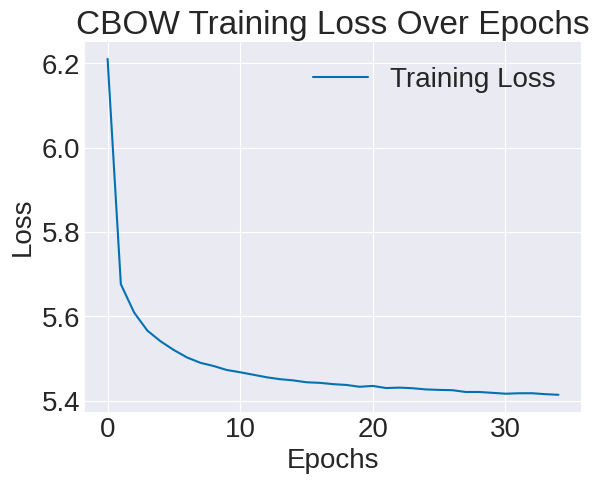

In [12]:
plt.plot(train_loss_hist, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CBOW Training Loss Over Epochs')
plt.legend()
plt.show()

### 2f. Get and save embeddings

To prevent having to retrain the CBOW network every time you want to access or analyze the word embeddings, I am providing a method `save_embeddings` that saves the network embeddings to disk in subfolder `export` in your working directory. 

<!-- **You will need to save your embeddings for sentiment analysis net week.**  -->

Here is how you would load the embeddings in the future after saving them:

```python
loaded_embeddings = np.load('export/embeddings.npz')
loaded_embeddings = loaded_embeddings['embeddings']
```

The `save_embeddings` method and forthcoming analysis will require getting all the embeddings from the network (`get_all_embeddings`) or only the embedding for one specific word (`get_word_embedding`). In `cbow.py`, write these methods.

#### Test: `get_all_embeddings` and `get_word_embedding`

In [13]:
tf.random.set_seed(0)
test_net = CBOW(input_feats_shape=(3,), C=3, embedding_dim=5)
test_net.compile()
print('All the embeddings are:')
print(test_net.get_all_embeddings().numpy())
print('and they should be:')
print('''[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]''')
print('The embedding for index 1 is')
print(test_net.get_word_embedding(1).numpy())
print('and it should be:')
print('''[ 0.2715 -0.0081  0.6864  0.3479  0.3462]''')

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Dense layer output(Hidden) shape: [1, 5]
---------------------------------------------------------------------------
All the embeddings are:
[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]
and they should be:
[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]
The embedding for index 1 is
[ 0.2715 -0.0081  0.6864  0.3479  0.3462]
and it should be:
[ 0.2715 -0.0081  0.6864  0.3479  0.3462]


Run/adapt the following cell to save your embeddings to disk (`net` is your net trained on the reviews).

In [14]:
model.save_embeddings()

## Task 3: Visualizing word embeddings with t-SNE

In this task, you will use the **cosine similarity** metric to find the words that have the most similar embedding to some query words of your choice. You will use the [t-SNE dimensionality reduction algorithm ](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) built into scikit-learn to visualize in 2D the relative positioning of the query word and words with the highest cosine similarity.

### 3a. Implement cosine similarity to get the most similar words to a query word

Given a word that we are interested in, the cosine similarity will find the $k$ words that have the most similar embeddings to that of the query word.

Here is a refresher on the cosine similarity equation:

$$
\text{Cosine Similarity} = \frac{(\text{Wts})(\vec{w})}{\sqrt{\sum_{j=1}^H (\text{Wts}^T)_j^2} \sqrt{\sum_{j=1}^H w_j^2}}
$$

Where $\text{Wts}$ are all the embeddings, $\text{Wts}^T$ is the transpose of the embeddings, $\vec{w}$ is the word embedding vector for the query word.


In [0]:
from amazon_reviews import get_most_similar_words

#### Test: `get_most_similar_words`

In [0]:
test_word_str2int = {
                     'Waterville': 0,
                     'Acadia': 1,
                     'Camden': 2,
                     'Portland': 3,
                     'Boothbay': 4,
                     'Bangor': 5,
                     'Kennebunkport': 6
                    }
test_word_int2str = {
                     0: 'Waterville',
                     1: 'Acadia',
                     2: 'Camden',
                     3: 'Portland',
                     4: 'Boothbay',
                     5: 'Bangor',
                     6: 'Kennebunkport'
                    }

test_word_str = 'Waterville'
tf.random.set_seed(0)
test_embeddings = tf.random.uniform(shape=(7, 4)).numpy()
test_top_inds, test_top_sims = get_most_similar_words(k=3,
                                                      all_embeddings=test_embeddings,
                                                      word_str=test_word_str,
                                                      word_str2int=test_word_str2int)

print(f'Words most similar to {test_word_str}:')
for k0 in range(len(test_top_inds)):
    print(f'{k0}: {test_word_int2str[test_top_inds[k0]]} (similarity={test_top_sims[k0]:.4f})')

### 3b. Use t-SNE to perform dimensionality reduction on the embeddings.

In the cell below:
1. Use [scikit-learn's TSNE class](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the dimensionality of the learned Amazon word embeddings down to 2D so that we will be able to visualize them in a scatter plot.
2. Assign the original embeddings to a variable `embeddings`.
3. Assign the 2D embeddings to a variable `word_tnse`. Make sure `embeddings` is a NumPy ndarray rather than a TF tensor.

In [0]:
from sklearn.manifold import TSNE
from amazon_reviews import find_unique_word_counts

### 3c. Create word cloud from Amazon Fashion review embeddings

In the cell below:

1. Name the word string-to-int map `word2ind` and the word index int-to-string map `ind2word` for the Amazon Fashion dataset.
2. Name the vocabulary for the Amazon Fashion dataset `vocab`.

Pick a word for `query_word` (has it be in the vocab) and run the cell below to show the words with the 25 most similar embeddings as well as a scatter plot, which shows all the word embeddings but annotates the query word and the most similar words.

**Note:** At least to start, pick query words among those that appear the most in the corpus. Code two cells down lists these most frequent words.

In [0]:
query_word = 'great'
topk_word_inds, topk_cossim = get_most_similar_words(k=25,
                                                     all_embeddings=embeddings,
                                                     word_str=query_word,
                                                     word_str2int=word2ind)


word_strs = [ind2word[ind] for ind in topk_word_inds]

print(f'Words most similar to {query_word}:')
for k0 in range(len(topk_word_inds)):
    print(f'{k0}: {ind2word[topk_word_inds[k0]]} (similarity={topk_cossim[k0]:.4f})')

# Visualize word cloud — each word as (x, y) coords
plt.figure(figsize=(40, 40))
plt.scatter(word_tnse[:, 0], word_tnse[:, 1])

max_xy = 5
rng = np.random.default_rng(0)
offsets = rng.uniform(low=-max_xy, high=max_xy, size=(len(word_strs), 2))
for w in range(len(word_strs)):
    plt.annotate(word_strs[w], (word_tnse[w, 0]+offsets[w,0], word_tnse[w, 1]+offsets[w,0]), fontsize=30)

plt.title('Word Embeddings (2D t-SNE)')
plt.xlabel('Embedding dim 1')
plt.ylabel('Embedding dim 2')
plt.show()

Print the words that appear most often in the Amazon Fashion corpus.

In [0]:
# TODO: modify variable name `corpus` to refer to your Amazon Fashion corpus
unique_word_counts = find_unique_word_counts(corpus=corpus)
top_k = 100

print(f'Top {top_k} words (by count in corpus):')
i = 0
for word, count in unique_word_counts.items():
    print(word, count)
    i += 1

    if i > top_k:
        break

### 3d. Questions

**Question 1:** Have some fun looking up word similarities. Which similarities do you like best / find the most interesting?

**Question 2:** Do the most similar words tend to show up nearby or far from one another in the word cloud?

**Question 3:** Why does the quality of the similar words improve for words that are more frequent in the corpus?

**Answer 1:** 

**Answer 2:** 

**Answer 3:** 

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. Analyze effect of embedding dimension

- Systematically vary the embedding dimension. How does the embedding dimension affect the quality of similar words based on their embeddings / cosine similarity?

#### 2. Amount of data

How does the size of the dataset (number of reviews) affect the quality of the embeddings?

#### 3. Improve text preprocessing

Try implementing and seeing how any of the following may change the quality of embeddings:

**Stemming:** Currently words with different suffixes are treated the same — e.g. "run", "runs", "running", etc. Normalize these so they map the same word.

**Remove stop words:** Remove common "filler" words that have little meaning — e.g. "a", "the", "an", etc.

**Misspelled words**: There are numerous misspellings of words in the corpus. Does having them in the vocab help or hurt?

If things improve/worsen, why might this be the case?

#### 4. Other text dataset of your choice

Obtain and preprocess a text dataset of your choice. Then either train on CBOW and visualize/analyze embeddings.

#### 5. Sentiment analysis

(*This is a more involved/challenging extension*) Use the word embedding vectors as data samples into another neural network whose job it is to predict whether either the word or the Amazon review to which it and other words in the review belong is positive (say >3 star rating) or negative (say < 3 star rating). 

For predicting the sentiment of words, you can use a simple heuristic to get the +/- label for individual words: If the word belongs to more + reviews than - reviews, then the word is a + word (and vice versa).

#### 6. Other dimensionality reduction techniques

Explore how different dimensionality reduction techniques alter the visualization/clustering of the words. *Keep in mind that many algorithms have hyperparameters and if one algorithm gives poor results, you should explore other hyperparameter values before concluding the algorithm does a poor job.*

Some popular ideas:
- PCA
- UMAP
- Self-organizing map (SOM)